# ***Check GPU connect***

In [1]:
print("oke")

oke


In [2]:
!nvidia-smi

Sun Sep 15 13:23:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch 
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.4.0
True
Tesla T4


# ***Content***

## Load dataset

In [4]:
!pip install modin[ray]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00a 0:00:01


In [5]:
import modin.pandas as pd 

PATH = '/kaggle/input/flight-trajectory-dataset/9columns_and_nullcallsign_dropped_flights_data.csv'
df = pd.read_csv(PATH)
df

2024-09-15 13:24:08,185	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-15 13:24:12,645	INFO worker.py:1753 -- Started a local Ray instance.
2024-09-15 13:24:15,657	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


,time,icao24,lat,lon,velocity,heading,callsign,baroaltitude,geoaltitude
0,1478874137,aaa83f,33.798321,-84.475651,221.557599,348.481341,EJA786,12184.38,NaN
1,1478874138,aaa83f,33.798321,-84.475651,221.557599,348.481341,EJA786,12184.38,NaN
2,1478874139,aaa83f,33.798321,-84.475651,221.557599,348.481341,EJA786,12184.38,NaN
3,1478874140,aaa83f,33.798321,-84.475651,221.557599,348.481341,EJA786,12184.38,NaN
4,1478874141,aaa83f,33.798321,-84.475651,221.557599,348.481341,EJA786,12184.38,NaN
...,...,...,...,...,...,...,...,...,...
21767252,1585086964,a80a97,33.825182,-84.478054,195.64908,349.546929,ASQ4014,11582.40,11940.54
21767253,1585086965,a80a97,33.827137,-84.478455,195.143196,349.519524,ASQ4014,11582.40,11940.54
21767254,1585086966,a80a97,33.830246,-84.479146,195.143196,349.519524,ASQ4014,11582.40,11940.54
21767255,1585086967,a80a97,33.831757,-84.479482,195.143196,349.519524,ASQ4014,11582.40,11940.54


In [6]:
df = df[['time', 'icao24', 'lat', 'lon']]
df

,time,icao24,lat,lon
0,1478874137,aaa83f,33.798321,-84.475651
1,1478874138,aaa83f,33.798321,-84.475651
2,1478874139,aaa83f,33.798321,-84.475651
3,1478874140,aaa83f,33.798321,-84.475651
4,1478874141,aaa83f,33.798321,-84.475651
...,...,...,...,...
21767252,1585086964,a80a97,33.825182,-84.478054
21767253,1585086965,a80a97,33.827137,-84.478455
21767254,1585086966,a80a97,33.830246,-84.479146
21767255,1585086967,a80a97,33.831757,-84.479482


In [7]:
df.columns = ['time', 'code', 'x', 'y']
df

,time,code,x,y
0,1478874137,aaa83f,33.798321,-84.475651
1,1478874138,aaa83f,33.798321,-84.475651
2,1478874139,aaa83f,33.798321,-84.475651
3,1478874140,aaa83f,33.798321,-84.475651
4,1478874141,aaa83f,33.798321,-84.475651
...,...,...,...,...
21767252,1585086964,a80a97,33.825182,-84.478054
21767253,1585086965,a80a97,33.827137,-84.478455
21767254,1585086966,a80a97,33.830246,-84.479146
21767255,1585086967,a80a97,33.831757,-84.479482


## Fomrat for each column and rows 

#### code 

In [8]:
from sklearn.preprocessing import LabelEncoder

df['nlb_code'] = df['code'].copy() 
le = LabelEncoder()
df['code'] = le.fit_transform(df['code'])

In [9]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 21767257 entries, 0 to 21767256
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   time      int64 
 1   code      int64 
 2   x         object
 3   y         object
 4   nlb_code  object
dtypes: int64(2), object(3)
memory usage: 830.4+ MB


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import random 

def df_info(df, sam_k=1000): 
    for col in df.columns:
        print(f"Column: {col}")
        print(f"  Type: {df[col].dtype}")

        s = random.sample(list(df[col]), sam_k)
        print(type(s[0]), s[0])
        a = [x for x in s if(type(x) == str)]
        print(a) 

        try:
            print(f"  Range: ({min(s)}, {max(s)})")
        except Exception as e: 
            print(e)

        print(f"  Number of Non-Null values: {df[col].count()}")
        print(f"  Number of Null values: {df[col].isnull().sum()}")
        print("-" * 20)
        
df_info(df) 

Column: time
  Type: int64
<class 'int'> 1505604485
[]
  Range: (1480445590, 1585049018)
  Number of Non-Null values: 21767257
  Number of Null values: 0
--------------------
Column: code
  Type: int64
<class 'int'> 9075
[]
  Range: (61, 17698)
  Number of Non-Null values: 21767257
  Number of Null values: 0
--------------------
Column: x
  Type: object
<class 'float'> 33.81354380462129
['33.81500244140625', '33.81345070014566', '33.814288640426376']
'<' not supported between instances of 'str' and 'float'
  Number of Non-Null values: 21767257
  Number of Null values: 0
--------------------
Column: y
  Type: object
<class 'float'> -84.42575454711914
['-84.43382263183594']
'<' not supported between instances of 'str' and 'float'
  Number of Non-Null values: 21767257
  Number of Null values: 0
--------------------
Column: nlb_code
  Type: object
<class 'str'> ab37d6
['ab37d6', 'a8faa6', 'a5628c', 'a16273', 'a0f31d', 'a4bdb9', 'a774b7', 'acc5aa', 'a9335a', 'ace31a', 'a3e525', 'ac382e', 'a

### x, y 

In [11]:
new_df = df.copy() 
new_df['x'] = pd.to_numeric(df['x'], errors='coerce')
new_df['y'] = pd.to_numeric(df['y'], errors='coerce')

In [12]:
df_info(new_df)

Column: time
  Type: int64
<class 'int'> 1570143321
[]
  Range: (1479212750, 1584921366)
  Number of Non-Null values: 21767257
  Number of Null values: 0
--------------------
Column: code
  Type: int64
<class 'int'> 17133
[]
  Range: (68, 17774)
  Number of Non-Null values: 21767257
  Number of Null values: 0
--------------------
Column: x
  Type: float64
<class 'float'> 33.816430043366
[]
  Range: (33.75018620895127, 33.84951782226562)
  Number of Non-Null values: 21767256
  Number of Null values: 1
--------------------
Column: y
  Type: float64
<class 'float'> -84.42026138305664
[]
  Range: (-84.47982788085938, -84.38003540039062)
  Number of Non-Null values: 21767256
  Number of Null values: 1
--------------------
Column: nlb_code
  Type: object
<class 'str'> a332eb
['a332eb', 'a4d5b7', 'ac4963', 'aba7b0', 'a7561b', 'a8d327', 'a4d4b3', 'ad111d', 'acea76', 'a12625', 'a77ae0', 'ac3b24', 'a0ddff', 'ab3982', 'a2dea7', 'a34ae0', 'a98edc', 'a55d6a', 'abc07b', 'a18d60', 'a8a015', 'a36110',

In [13]:
df = new_df.dropna(subset=['x', 'y'])

In [14]:
df_info(df) 

Column: time
  Type: int64
<class 'int'> 1567517299
[]
  Range: (1479388299, 1585074644)
  Number of Non-Null values: 21767255
  Number of Null values: 0
--------------------
Column: code
  Type: int64
<class 'int'> 4655
[]
  Range: (207, 17875)
  Number of Non-Null values: 21767255
  Number of Null values: 0
--------------------
Column: x
  Type: float64
<class 'float'> 33.813491821289055
[]
  Range: (33.75004655223782, 33.8499755859375)
  Number of Non-Null values: 21767255
  Number of Null values: 0
--------------------
Column: y
  Type: float64
<class 'float'> -84.40143585205078
[]
  Range: (-84.4797134399414, -84.38009262084961)
  Number of Non-Null values: 21767255
  Number of Null values: 0
--------------------
Column: nlb_code
  Type: object
<class 'str'> a06b03
['a06b03', 'a9b837', 'a42f04', 'a41b89', 'a43b45', 'a8f9c6', 'a2c62b', 'a2313f', 'a3d890', 'ac8d30', 'a7f294', 'a443e8', 'a7debf', 'a87f51', 'a8d327', 'a18ec2', 'a6e342', 'a049f0', 'a4b21b', 'aded09', 'a426a5', 'a086ce'

### reset rows

In [15]:
df = df.sort_values(by=['time'])

In [16]:
df = df.reset_index(drop=True)

### time 

In [17]:
df['org_time'] = df['time'].copy()
df['time'] = df['time'] - df['time'].iloc[0] 

In [18]:
df

,time,code,x,y,nlb_code,org_time
0,0,13074,33.798321,-84.475651,aaa83f,1478874137
1,1,13074,33.798321,-84.475651,aaa83f,1478874138
2,2,13074,33.798321,-84.475651,aaa83f,1478874139
3,3,13074,33.798321,-84.475651,aaa83f,1478874140
4,4,13074,33.798321,-84.475651,aaa83f,1478874141
...,...,...,...,...,...,...
21767250,106212827,10190,33.825182,-84.478054,a80a97,1585086964
21767251,106212828,10190,33.827137,-84.478455,a80a97,1585086965
21767252,106212829,10190,33.830246,-84.479146,a80a97,1585086966
21767253,106212830,10190,33.831757,-84.479482,a80a97,1585086967


## Plot trajectory 

In [19]:
len(df['code'].unique())

17903

In [20]:
CODES = sorted(df['code'].unique().tolist()) 
print(len(CODES), CODES[:10]) 

17903 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [21]:
def plot_some_trajectory(k=5): 
    codes = random.sample(CODES, k)
    for code in codes: 
        trajectory = df[df['code'] == code]
        print(trajectory) 
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(trajectory['x'], trajectory['y'], marker='o', linestyle='-')
        plt.subplot(1, 2, 2) 
        plt.plot(trajectory['time'])
        plt.show() 

              time   code          x          y nlb_code    org_time
2764841   27337737  14630  33.752328 -84.386330   abd693  1506211874
2764842   27337738  14630  33.752328 -84.386330   abd693  1506211875
2764843   27337739  14630  33.752002 -84.389133   abd693  1506211876
2764844   27337740  14630  33.751816 -84.390793   abd693  1506211877
2764845   27337741  14630  33.751676 -84.391823   abd693  1506211878
...            ...    ...        ...        ...      ...         ...
11997050  77419793  14630  33.817932 -84.384753   abd693  1556293930
11997055  77419794  14630  33.817932 -84.384753   abd693  1556293931
11997058  77419795  14630  33.818069 -84.382287   abd693  1556293932
11997059  77419796  14630  33.818161 -84.381054   abd693  1556293933
11997063  77419797  14630  33.818246 -84.380150   abd693  1556293934

[75 rows x 6 columns]


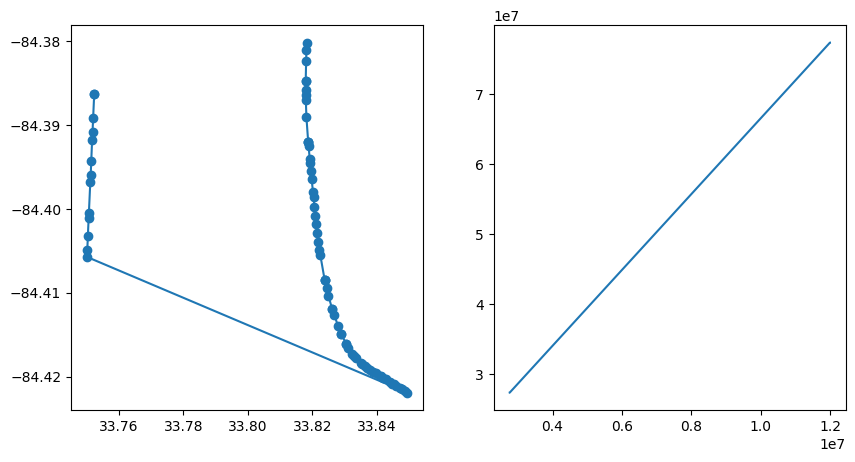

               time   code          x          y nlb_code    org_time
9706744    65706538  16913  33.753119 -84.465179   adbdc9  1544580675
9706745    65706539  16913  33.755028 -84.465637   adbdc9  1544580676
9706746    65706540  16913  33.757645 -84.466310   adbdc9  1544580677
9706747    65706541  16913  33.758331 -84.466478   adbdc9  1544580678
9706748    65706542  16913  33.758331 -84.466478   adbdc9  1544580679
...             ...    ...        ...        ...      ...         ...
21431221  105178289  16913  33.812622 -84.390358   adbdc9  1584052426
21431222  105178290  16913  33.812613 -84.388103   adbdc9  1584052427
21431223  105178291  16913  33.812622 -84.386211   adbdc9  1584052428
21431224  105178292  16913  33.812613 -84.384098   adbdc9  1584052429
21431225  105178293  16913  33.812622 -84.382007   adbdc9  1584052430

[1604 rows x 6 columns]


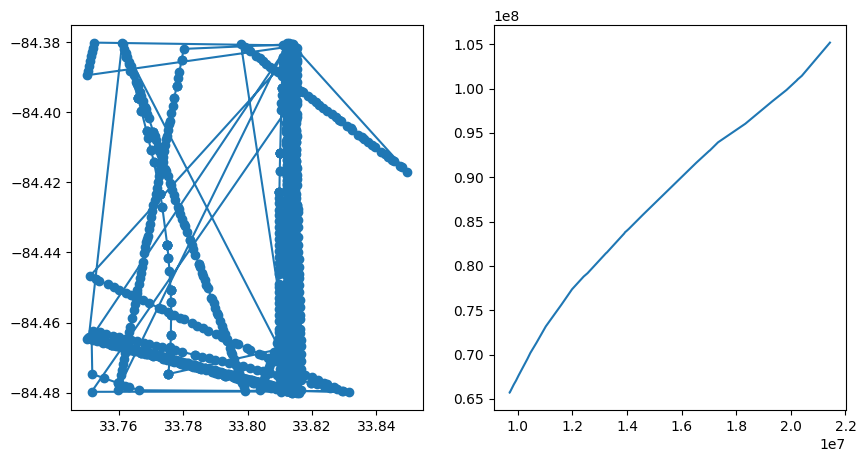

              time  code          x          y nlb_code    org_time
12510726  79069303  7112  33.813904 -84.380773   a54632  1557943440
12510728  79069304  7112  33.813870 -84.382839   a54632  1557943441
12510730  79069305  7112  33.813904 -84.384529   a54632  1557943442
12510732  79069306  7112  33.813870 -84.385300   a54632  1557943443
12510734  79069307  7112  33.813904 -84.387668   a54632  1557943444
...            ...   ...        ...        ...      ...         ...
18706140  96967381  7112  33.813870 -84.472160   a54632  1575841518
18706141  96967382  7112  33.813870 -84.474049   a54632  1575841519
18706142  96967383  7112  33.813904 -84.474830   a54632  1575841520
18706143  96967384  7112  33.813904 -84.477352   a54632  1575841521
18706144  96967385  7112  33.813950 -84.478922   a54632  1575841522

[1525 rows x 6 columns]


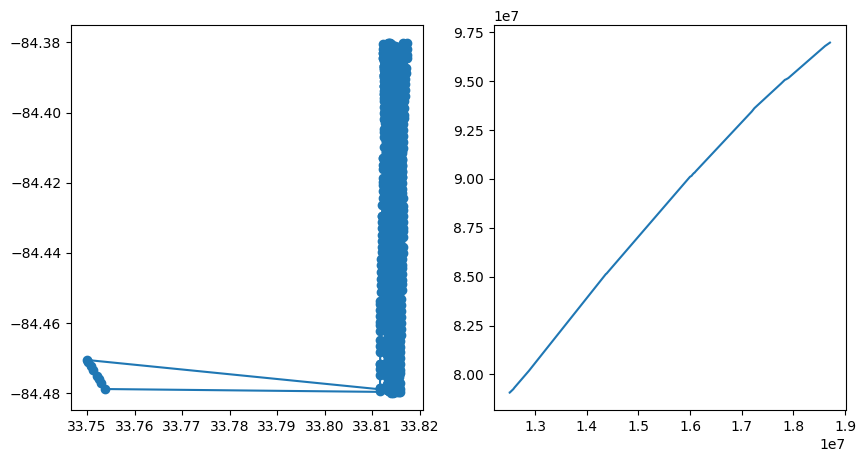

              time  code          x          y nlb_code    org_time
3335733   30778456  6815  33.776442 -84.480000   a4fc04  1509652593
3335734   30778457  6815  33.774902 -84.479762   a4fc04  1509652594
3335735   30778458  6815  33.773895 -84.479594   a4fc04  1509652595
3335736   30778459  6815  33.773136 -84.479485   a4fc04  1509652596
3335737   30778460  6815  33.772159 -84.479313   a4fc04  1509652597
...            ...   ...        ...        ...      ...         ...
15794347  89513176  6815  33.765362 -84.382210   a4fc04  1568387313
15794348  89513177  6815  33.766754 -84.381726   a4fc04  1568387314
15794350  89513178  6815  33.768435 -84.381065   a4fc04  1568387315
15794352  89513179  6815  33.769319 -84.380722   a4fc04  1568387316
15794354  89513180  6815  33.771011 -84.380101   a4fc04  1568387317

[1398 rows x 6 columns]


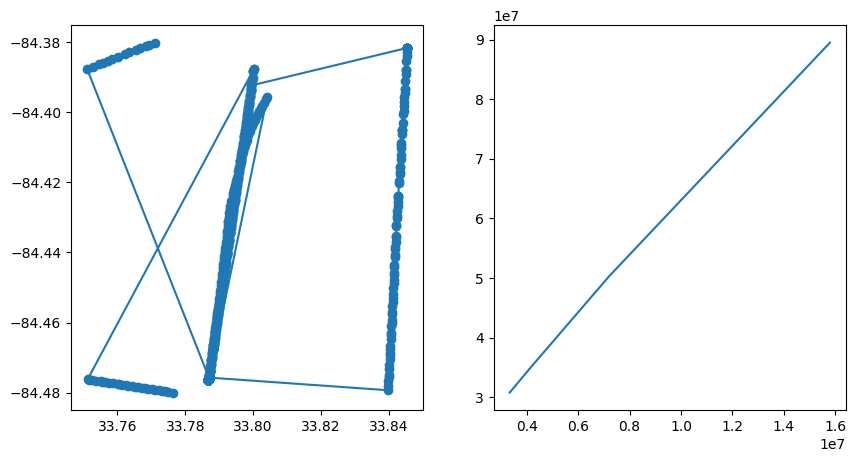

              time   code          x          y nlb_code    org_time
19699766  99546153  17294  33.833515 -84.383354   ae144e  1578420290
19699767  99546154  17294  33.833771 -84.385258   ae144e  1578420291
19699770  99546155  17294  33.834073 -84.387188   ae144e  1578420292
19699771  99546156  17294  33.834320 -84.389125   ae144e  1578420293
19699773  99546157  17294  33.834585 -84.391079   ae144e  1578420294
19699776  99546158  17294  33.834824 -84.392713   ae144e  1578420295
19699779  99546159  17294  33.835097 -84.394512   ae144e  1578420296
19699781  99546160  17294  33.835373 -84.396468   ae144e  1578420297
19699784  99546161  17294  33.835656 -84.398518   ae144e  1578420298
19699786  99546162  17294  33.835968 -84.400560   ae144e  1578420299
19699788  99546163  17294  33.836215 -84.402466   ae144e  1578420300
19699790  99546164  17294  33.836472 -84.404316   ae144e  1578420301
19699791  99546165  17294  33.836727 -84.406128   ae144e  1578420302
19699793  99546166  17294  33.8370

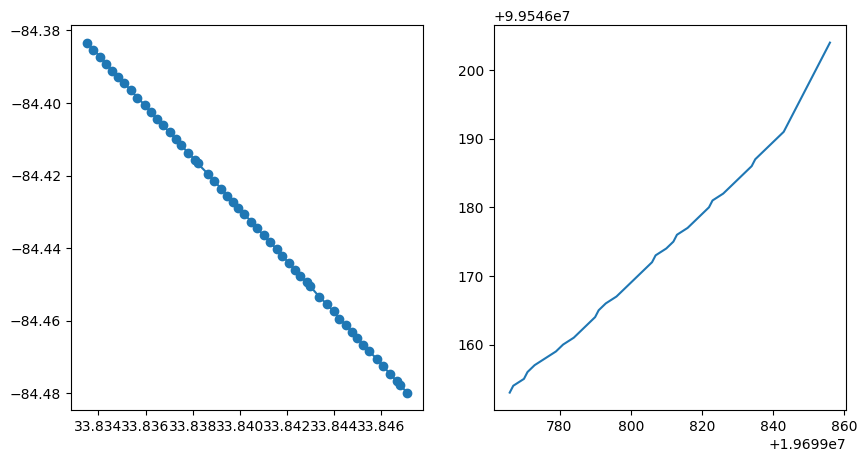

In [22]:
plot_some_trajectory()

In [23]:
# Group by 'Category' and calculate Min and Max  
grouped = df.groupby('code')['time'].agg(Min='min', Max='max').reset_index()

In [24]:
def plot_hist(data): 
    plt.figure(figsize=(10, 6))  

    # Plot histogram  
    plt.hist(data, bins=30, density=True, alpha=0.5, color='blue')  

    # Add labels and title  
    plt.title('Histogram of Distribution')  
    plt.xlabel('Value')  
    plt.ylabel('Density')  

    plt.grid()  
    plt.show()

In [25]:
def plot_density(x, y):
    plt.figure(figsize=(10, 6))  
    sns.kdeplot(x=x, y=y, fill=True, cmap='Blues', thresh=0, levels=20)  
    plt.title('Density Plot using Seaborn')  
    plt.xlabel('X-axis')  
    plt.ylabel('Y-axis')  
    plt.grid()  
    plt.show()

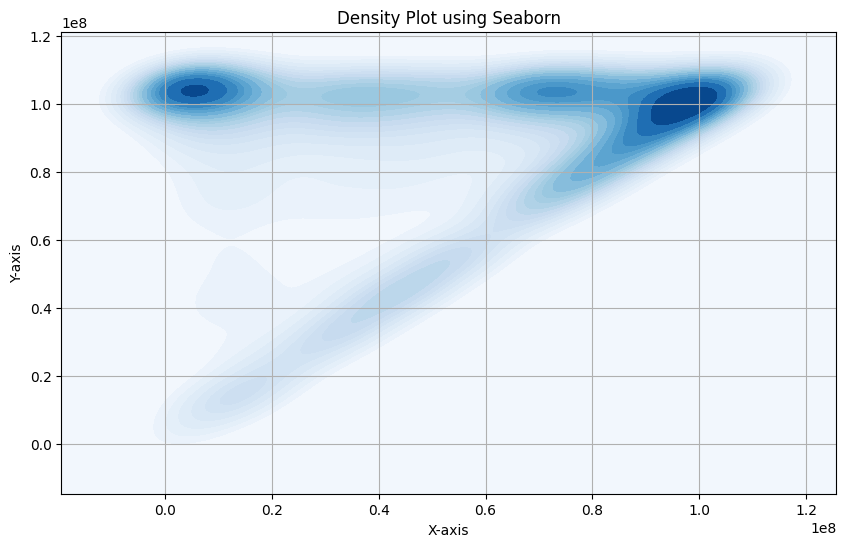

In [26]:
plot_density(grouped['Min'], grouped['Max'])

## Compress 

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df['org_x'] = df['x'].copy() 
df['org_y'] = df['y'].copy() 
df[['time', 'x','y']] = scaler.fit_transform(df[['time', 'x','y']])

In [28]:
for col in ['time', 'x', 'y']: 
    df[col] = df[col].round(2)

In [38]:
df_info(df)

Column: time
  Type: float64
<class 'float'> 0.84
[]
  Range: (0.01, 1.0)
  Number of Non-Null values: 21767255
  Number of Null values: 0
--------------------
Column: code
  Type: int64
<class 'int'> 5173
[]
  Range: (88, 17767)
  Number of Non-Null values: 21767255
  Number of Null values: 0
--------------------
Column: x
  Type: float64
<class 'float'> 0.99
[]
  Range: (0.0, 1.0)
  Number of Non-Null values: 21767255
  Number of Null values: 0
--------------------
Column: y
  Type: float64
<class 'float'> 0.0
[]
  Range: (0.0, 0.0)
  Number of Non-Null values: 21767255
  Number of Null values: 0
--------------------
Column: nlb_code
  Type: object
<class 'str'> a3df1e
['a3df1e', 'aa76ef', 'a52898', 'a3049c', 'a0acfd', 'a91349', 'a85f20', 'aa9b42', 'a3a503', 'aa6c0f', 'a6f777', 'a84699', 'a36fa4', 'a7e5b6', 'a7e5b6', 'aca996', 'a44a61', 'a45ba2', 'a4794e', 'ac820f', 'a19fdb', 'a0ec20', 'a06395', 'a47d05', 'a18ec2', 'a4f7f6', 'aa4c42', 'ae1ec5', 'a55785', 'a1a9ff', 'a5977f', 'a70b8c',

          time  code     x    y nlb_code    org_time      org_x      org_y
8806877   0.54  7785  0.88  0.0   a5fc42  1536303110  33.837799 -84.402017
8806878   0.54  7785  0.88  0.0   a5fc42  1536303111  33.837799 -84.402017
8806879   0.54  7785  0.88  0.0   a5fc42  1536303112  33.837799 -84.402017
8806880   0.54  7785  0.88  0.0   a5fc42  1536303113  33.837799 -84.402017
8806881   0.54  7785  0.88  0.0   a5fc42  1536303114  33.837799 -84.402017
...        ...   ...   ...  ...      ...         ...        ...        ...
18225056  0.90  7785  0.12  0.0   a5fc42  1574676419  33.761902 -84.387948
18225057  0.90  7785  0.12  0.0   a5fc42  1574676420  33.761871 -84.386215
18225058  0.90  7785  0.12  0.0   a5fc42  1574676421  33.761871 -84.384670
18225059  0.90  7785  0.12  0.0   a5fc42  1574676422  33.761824 -84.383011
18225060  0.90  7785  0.12  0.0   a5fc42  1574676423  33.761810 -84.381278

[183 rows x 8 columns]


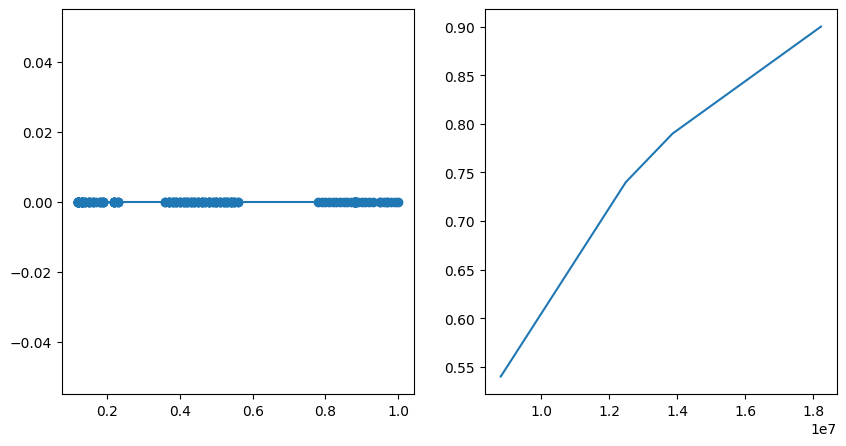

          time   code     x    y nlb_code    org_time      org_x      org_y
7559979   0.49  16122  0.44  0.0   ace79f  1530901301  33.794174 -84.380157
7559980   0.49  16122  0.46  0.0   ace79f  1530901302  33.796005 -84.381670
7559981   0.49  16122  0.47  0.0   ace79f  1530901303  33.796552 -84.382095
7559982   0.49  16122  0.49  0.0   ace79f  1530901304  33.798833 -84.383926
7559983   0.49  16122  0.49  0.0   ace79f  1530901305  33.799393 -84.384417
...        ...    ...   ...  ...      ...         ...        ...        ...
21242070  0.99  16122  0.07  0.0   ace79f  1583596372  33.756958 -84.465301
21242074  0.99  16122  0.06  0.0   ace79f  1583596373  33.755633 -84.464951
21242078  0.99  16122  0.03  0.0   ace79f  1583596374  33.753212 -84.464378
21242081  0.99  16122  0.02  0.0   ace79f  1583596375  33.751722 -84.464035
21242084  0.99  16122  0.01  0.0   ace79f  1583596376  33.750652 -84.463806

[291 rows x 8 columns]


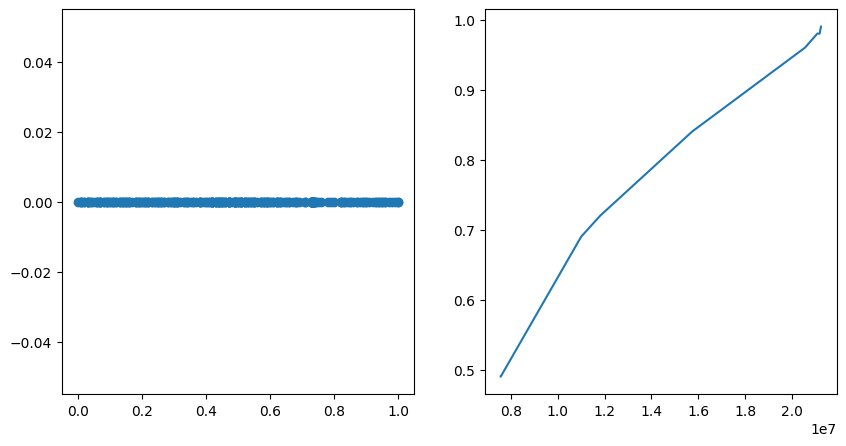

          time   code     x    y nlb_code    org_time      org_x      org_y
12802228  0.75  14556  0.98  0.0   abc759  1558736130  33.847760 -84.407730
12802231  0.75  14556  0.98  0.0   abc759  1558736131  33.847760 -84.407730
12802232  0.75  14556  0.97  0.0   abc759  1558736132  33.847000 -84.407679
12802234  0.75  14556  0.97  0.0   abc759  1558736133  33.846497 -84.407623
12802236  0.75  14556  0.96  0.0   abc759  1558736134  33.845898 -84.407558
...        ...    ...   ...  ...      ...         ...        ...        ...
18740736  0.91  14556  0.02  0.0   abc759  1575922814  33.751968 -84.441871
18740739  0.91  14556  0.02  0.0   abc759  1575922815  33.751740 -84.441927
18740741  0.91  14556  0.01  0.0   abc759  1575922816  33.751117 -84.442062
18740744  0.91  14556  0.01  0.0   abc759  1575922817  33.750916 -84.442095
18740749  0.91  14556  0.00  0.0   abc759  1575922818  33.750326 -84.442177

[908 rows x 8 columns]


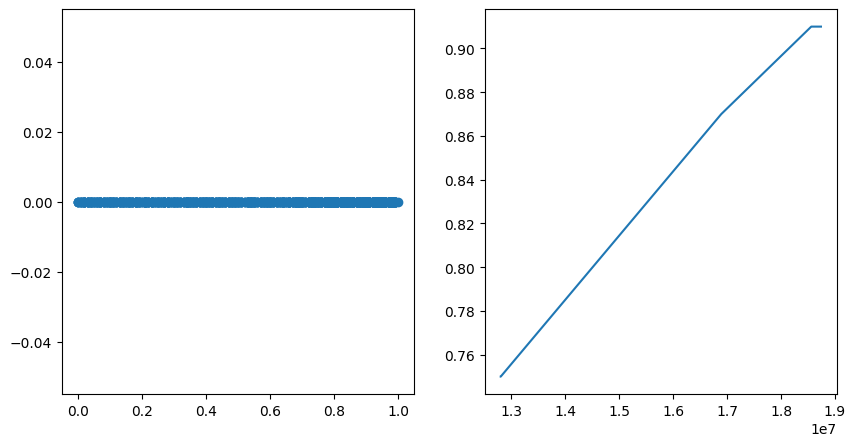

          time  code     x    y nlb_code    org_time      org_x      org_y
9169589   0.56  5104  0.76  0.0   a38513  1538576185  33.825787 -84.469185
9169590   0.56  5104  0.76  0.0   a38513  1538576186  33.825787 -84.469185
9169591   0.56  5104  0.72  0.0   a38513  1538576187  33.821777 -84.468216
9169592   0.56  5104  0.72  0.0   a38513  1538576188  33.821777 -84.468216
9169593   0.56  5104  0.67  0.0   a38513  1538576189  33.817291 -84.467095
...        ...   ...   ...  ...      ...         ...        ...        ...
21413862  0.99  5104  0.11  0.0   a38513  1584021856  33.761261 -84.447925
21413863  0.99  5104  0.09  0.0   a38513  1584021857  33.758845 -84.447384
21413864  0.99  5104  0.06  0.0   a38513  1584021858  33.756454 -84.446804
21413865  0.99  5104  0.06  0.0   a38513  1584021859  33.755539 -84.446523
21413866  0.99  5104  0.02  0.0   a38513  1584021860  33.751740 -84.445626

[1753 rows x 8 columns]


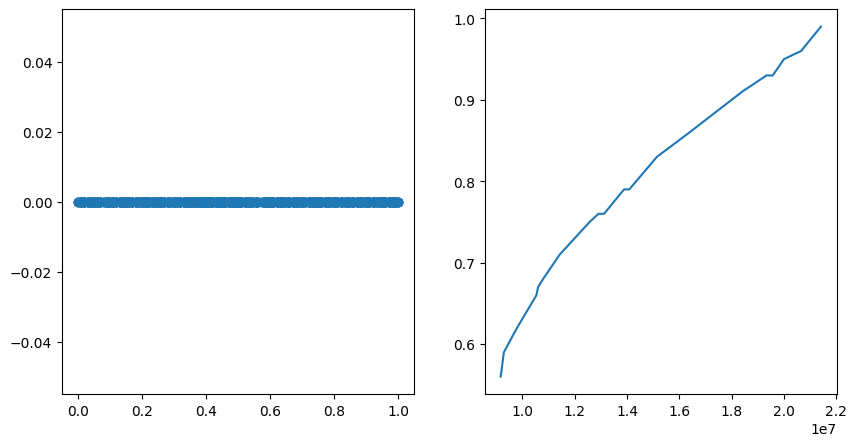

          time  code     x    y nlb_code    org_time      org_x      org_y
1869636   0.17   490  0.09  0.0   3c4b28  1497329190  33.759247 -84.436097
1869637   0.17   490  0.09  0.0   3c4b28  1497329191  33.759247 -84.436097
1869638   0.17   490  0.09  0.0   3c4b28  1497329192  33.759247 -84.436097
1869639   0.17   490  0.09  0.0   3c4b28  1497329193  33.759247 -84.436097
1869640   0.17   490  0.23  0.0   3c4b28  1497329194  33.772522 -84.414853
...        ...   ...   ...  ...      ...         ...        ...        ...
21386155  0.99   490  0.92  0.0   3c4b28  1583911538  33.841827 -84.390190
21386156  0.99   490  0.93  0.0   3c4b28  1583911539  33.843291 -84.387875
21386157  0.99   490  0.94  0.0   3c4b28  1583911540  33.844222 -84.386444
21386158  0.99   490  0.96  0.0   3c4b28  1583911541  33.845665 -84.384098
21386159  0.99   490  0.97  0.0   3c4b28  1583911542  33.847046 -84.382007

[137 rows x 8 columns]


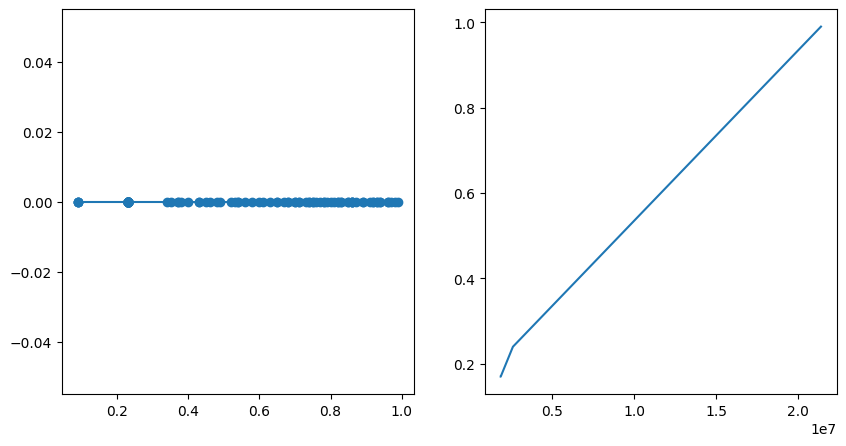

In [39]:
plot_some_trajectory()

In [ ]:
import pandas as pd  
from mlxtend.frequent_patterns import apriori, association_rules  

# Step 1: Data Collection  
# Example: Load trajectory data (assuming a CSV file)  
data = pd.read_csv('trajectory_data.csv')  # Your data file here  

# Sample structure of trajectory_data.csv:  
# | User_ID | Timestamp          | Latitude | Longitude |  
# |---------|--------------------|----------|-----------|  
# | 1       | 2023-01-01 08:00   | 40.7128  | -74.0060  |  
# | 1       | 2023-01-01 08:10   | 40.7138  | -74.0050  |  
# | 2       | 2023-01-01 08:15   | 40.7120  | -74.0070  |  

# Step 2: Data Preprocessing  
# 1. Convert the Timestamp to datetime  
data['Timestamp'] = pd.to_datetime(data['Timestamp'])  

# 2. Create a sequence of locations per user (discretization)  
data['Location'] = data['Latitude'].astype(str) + ',' + data['Longitude'].astype(str)  
trajectory_sequences = data.groupby('User_ID')['Location'].apply(list).reset_index()  

# Step 3: Transform the data for frequent pattern mining  
# Convert the trajectories into a one-hot encoded DataFrame  
sequence_df = trajectory_sequences['Location'].str.join(',')  # Join locations into a string  

# Generate dummy variables  
transactions = sequence_df.str.get_dummies(sep=',')  
print(transactions.head())  # Display the one-hot encoded DataFrame  

# Step 4: Pattern Mining using Apriori Algorithm  
# Set a minimum support threshold  
min_support = 0.05  # 5% support threshold  
frequent_itemsets = apriori(transactions, min_support=min_support, use_colnames=True)  

# Step 5: Generate Association Rules  
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)  

# Step 6: Analyze and Visualize the Results  
print("Frequent Itemsets:")  
print(frequent_itemsets)  

print("\nAssociation Rules:")  
print(rules)  

# Optional: Save the results to CSV  
frequent_itemsets.to_csv('frequent_itemsets.csv', index=False)  
rules.to_csv('association_rules.csv', index=False)  

# Visualization (optional, requires matplotlib)  
import matplotlib.pyplot as plt  
import seaborn as sns  

plt.figure(figsize=(10, 6))  
sns.scatterplot(data=rules, x='support', y='confidence', size='lift', sizes=(20, 200), alpha=0.5)  
plt.title('Association Rules')  
plt.xlabel('Support')  
plt.ylabel('Confidence')  
plt.show()

In [ ]:
import pandas as pd  
from pymining import seqmining  

# Step 1: Data Collection  
# Example: Load trajectory data (assuming a CSV file)  
data = pd.read_csv('trajectory_data.csv')  # Your data file here  

# Sample structure of trajectory_data.csv:  
# | User_ID | Timestamp          | Latitude | Longitude |  
# |---------|--------------------|----------|-----------|  
# | 1       | 2023-01-01 08:00   | 40.7128  | -74.0060  |  
# | 1       | 2023-01-01 08:10   | 40.7138  | -74.0050  |  
# | 2       | 2023-01-01 08:15   | 40.7120  | -74.0070  |  

# Step 2: Data Preprocessing  
# Convert the Timestamp to datetime  
data['Timestamp'] = pd.to_datetime(data['Timestamp'])  

# Create a sequence of locations per user (discretization)  
data['Location'] = data['Latitude'].astype(str) + ',' + data['Longitude'].astype(str)  
trajectory_sequences = data.groupby('User_ID')['Location'].apply(list).reset_index()  

# Step 3: Prepare data for PrefixSpan  
# Convert the sequences into the required format for PrefixSpan  
sequences = trajectory_sequences['Location'].tolist()  

# Convert user-location sequences into a list of lists (format: [[location1, location2], ...])  
formatted_sequences = [[location for location in seq] for seq in sequences]  

# Step 4: Run PrefixSpan  
# Set the minimum support  
min_support = 2  # Adjust this based on your data size  

# Run PrefixSpan  
frequent_patterns = seqmining.frequent_sequences(formatted_sequences, min_support)  
print("Frequent Patterns:")  
for pattern in frequent_patterns:  
    print(pattern)  

# Optional: Analyze patterns further (e.g., filtering based on length, etc.)

In [ ]:
import matplotlib.pyplot as plt  
import seaborn as sns  

# Example: Analyze and visualize results based on identified patterns  
# Convert patterns for visualization  
pattern_counts = pd.DataFrame(frequent_patterns, columns=['Pattern', 'Count'])  

# Plotting the frequency of patterns  
plt.figure(figsize=(12, 6))  
sns.barplot(x='Pattern', y='Count', data=pattern_counts)  
plt.title('Frequency of Sequential Patterns')  
plt.xlabel('Pattern')  
plt.ylabel('Frequency')  
plt.xticks(rotation=45)  
plt.show()